In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (212 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import shutil
import random
from PIL import Image
from skimage.color import rgb2gray

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Fetch Slides from URL and upload to Google Drive
(skip if slides are already in google drive)

In [ ]:
# make a dir to store the slides from curl download
!mkdir slides

In [ ]:
# randomly choose the slides
slide_num = ['016', '064', '075', '084', '091', '094', '101', '110']
slide_url = 'https://storage.googleapis.com/applied-dl/tumor-slides'
slide_files = [('tumor_' + num + '.tif') for num in slide_num]
tumor_mask_files = [('tumor_' + num + '_mask.tif') for num in slide_num]

print(slide_files)
print(tumor_mask_files)

['tumor_016.tif', 'tumor_064.tif', 'tumor_075.tif', 'tumor_084.tif', 'tumor_091.tif', 'tumor_094.tif', 'tumor_101.tif', 'tumor_110.tif']
['tumor_016_mask.tif', 'tumor_064_mask.tif', 'tumor_075_mask.tif', 'tumor_084_mask.tif', 'tumor_091_mask.tif', 'tumor_094_mask.tif', 'tumor_101_mask.tif', 'tumor_110_mask.tif']


In [ ]:
# download slides to store locally then move to drive
for slide in slide_files:
  if not os.path.exists(slide) and not os.path.exists("/content/slides/"+slide):
    slide_path = os.path.join(slide_url, slide)
    !curl -O $slide_path
    shutil.move(slide, "/content/slides")

for mask in tumor_mask_files:
  if not os.path.exists(mask) and not os.path.exists("/content/slides/"+mask):
    slide_path = os.path.join(slide_url, mask)
    !curl -O $slide_path
    shutil.move(mask, "/content/slides")

In [ ]:
shutil.move('/content/slides', '/content/drive/MyDrive/ADL_Project')

'/content/drive/MyDrive/ADL_Project/slides'

## Visualization
an example of slide and tumor mask would be demonstrated below. Sanity checks would be performed as well

In [5]:
root = '/content/gdrive/MyDrive/ADL_Project/slides'

slide_path = os.path.join(root,'tumor_016.tif')
tumor_mask_path = os.path.join(root,'tumor_016_mask.tif')

slide = open_slide(slide_path)
# print(slide.level_dimensions)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
# print(tumor_mask.level_dimensions)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(tumor_mask.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/gdrive/MyDrive/ADL_Project/slides/tumor_016.tif with width: 97792, height: 221184
Read tumor mask from /content/gdrive/MyDrive/ADL_Project/slides/tumor_016_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256


In [6]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

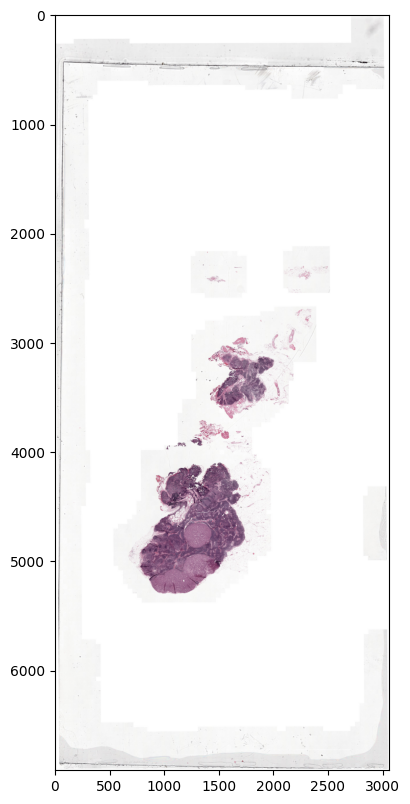

In [7]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

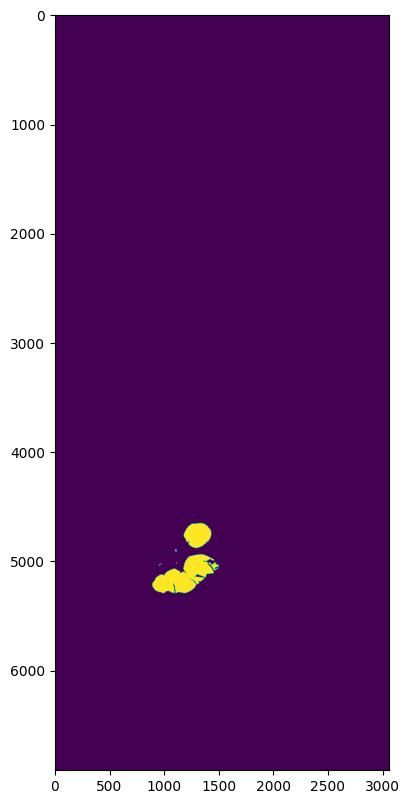

In [8]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [9]:
# the resulting mask_image numpy array will contain only 0, 1
np.unique(mask_image, return_counts=True)

(array([0, 1], dtype=uint8), array([20966091,   156981]))

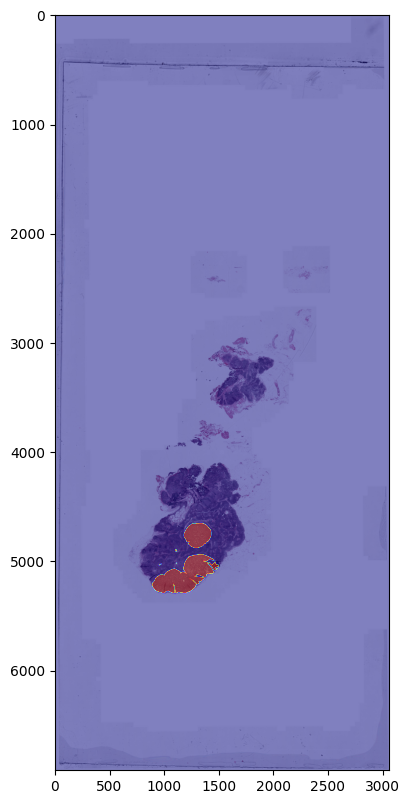

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

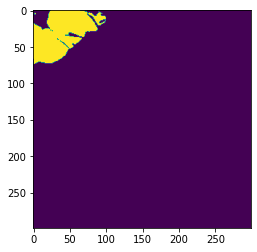

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
region = read_slide(tumor_mask, x= 275 * 128, y=1250 * 128, level=7, width=299, height=299)[:,:,0]
plt.imshow(region)

In [10]:
def find_tissue_pixels(image, intensity=0.8, margin=0.1):
    """
    Ignore non-tissue pixel to improve efficiency
    input: image, intensity of the color 
    output: indices of tissues
    """
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    pixels = list(zip(indices[0], indices[1]))
    # exclude possible noise on the margin
    x_margin = image.shape[0]*margin
    y_margin = image.shape[1]*margin
    return [(i, j) for i,j in pixels if (i>x_margin and i<image.shape[0]-x_margin and j>y_margin and j<image.shape[1]-y_margin)]

def apply_mask(im, mask, color=(255,0,0)):
    """
    input: image, mask indeices
    output: np array (image with red mask to signify tissues)
    """
    masked = np.copy(im)
    for x,y in mask: 
      masked[x][y] = color
    return masked

def find_tissue_percentage(slide_image):
  return len(find_tissue_pixels(slide_image)) / float(slide_image.shape[0] * slide_image.shape[1]) * 100

956859 tissue_pixels pixels (4.5 percent of the image)


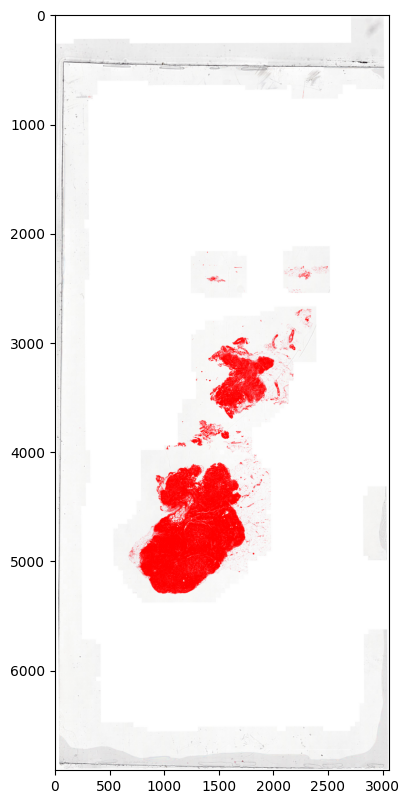

In [11]:
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = find_tissue_percentage(slide_image)
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(tissue_regions)

## Functions for preprocessing


#### get label of the patch
see if the center 128*128 contains any tumor

In [7]:
def get_label(mask, center_size=128, patch_size=299):
  """
  input: mask_image
  output: 1 if the center contains any tumor and 0 otherwise
  """
  gap = (patch_size-center_size)//2
  num_tumor_cells = np.sum(mask[gap:gap+center_size, gap:gap+center_size])
  return int(num_tumor_cells>0)

Sanity check

class label: 1


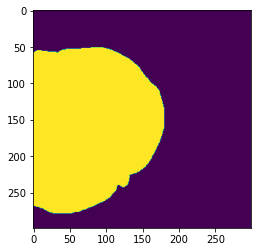

In [ ]:
region = read_slide(tumor_mask, x= 1250 * 32, y=4600 * 32, level=5, width=299, height=299)[:,:,0]
plt.imshow(region)
print("class label:", get_label(region))

class label: 0


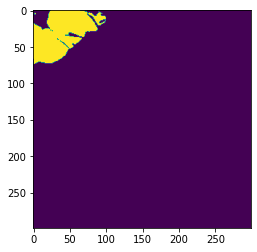

In [ ]:
region = read_slide(tumor_mask, x= 275 * 128, y=1250 * 128, level=7, width=299, height=299)[:,:,0]
plt.imshow(region)
print("class label:", get_label(region))

#### Get random 299*299 patches from the slide and mask_image


In [8]:
def get_patch(slide, tumor_mask, x, y, zoom_level, patch_size=299):
  """
  input: x,y are randomly generated center of image
  output: 299*299 patch from the slide
  """
  x = int(x)
  y = int(y)
  side = int(patch_size//2 * slide.level_downsamples[zoom_level])

  patch = read_slide(slide, 
                     x=x-side,
                     y=y-side, 
                     level=zoom_level, 
                     width=patch_size, 
                     height=patch_size)
  mask = read_slide(tumor_mask, 
                    x=x-side,
                    y=y-side, 
                    level=zoom_level, 
                    width=patch_size, 
                    height=patch_size)[:,:,0]
  return patch, mask

#### Get locations of the normal tissues and tumors
Use `find_tissue_pixels` and `apply_mask` from before so that we could speed up computation by generating patches only from locations where tissues exist.

In [9]:
def get_tissue_pixels(slide, tumor_mask, zoom_level=5, patch_size=299):
  """
  input: slide and tumor_mask, using default zoom_level=5, and 
         patch of size 299*299
  output: indices of normal pixels and tumor pixels (y, x) 
  """
  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=zoom_level, 
                          width=slide.level_dimensions[zoom_level][0], 
                          height=slide.level_dimensions[zoom_level][1])
  mask_image = read_slide(tumor_mask, 
                          x=0,
                          y=0, 
                          level=zoom_level, 
                          width=tumor_mask.level_dimensions[zoom_level][0], 
                          height=tumor_mask.level_dimensions[zoom_level][1])[:,:,0]
  
  assert slide_image.shape[:2] == mask_image.shape

  # to be a valid center, it can't lay on the margin with width and height patch_size//2
  half_patch_size = patch_size//2
  crop_slide = slide_image[half_patch_size:-half_patch_size, half_patch_size:-half_patch_size]
  crop_mask = mask_image[half_patch_size:-half_patch_size, half_patch_size:-half_patch_size]

  # find indices of tissu pixels
  tissue_pixels = find_tissue_pixels(crop_slide) # get (y,x) pairs
  tissue_regions = apply_mask(crop_slide, tissue_pixels)
  assert tissue_regions.shape[:2] == crop_mask.shape
  # normal_pixel = list(zip(*np.nonzero(tissue_regions[:,:,0]-255*crop_mask)))
  tumor_pixel = list(zip(*np.nonzero(crop_mask)))
  normal_pixel = list(set(tissue_pixels)-set(tumor_pixel))

  return normal_pixel, tumor_pixel

In [ ]:
# normal_pixel, tumor_pixel = get_tissue_pixels(slide, tumor_mask)

#### Generate patches
(skip if patches are in google drive)

In [10]:
def patch_generator(slides, tumor_masks, zoom_level_1, zoom_level_2, 
                    tissue_percentage=30, base_zoom_level=5, center_size=128, patch_size=299, n_sample=250):
  """
  output: patches from zoom_level_1, patches from zoom_level_2, labels for each
  """
  half_patch_size = patch_size//2
  patch_level_1 = []
  patch_level_2 = []
  labels = []

  for i, (slide, tumor_mask) in enumerate(zip(slides, tumor_masks)):
    # get top left corner of the patch
    normal_pixel, tumor_pixel = get_tissue_pixels(slide, tumor_mask, base_zoom_level, patch_size)
    normal_len = len(normal_pixel)
    tumor_len = len(tumor_pixel)
    print('processing slide: {}, length of normal pixel: {}, length of tumor pixel: {}'.format(i+1, normal_len, tumor_len))
    # get center of the patch and adjust it back to (x,y) pair
    normal_pixel = [(x + half_patch_size, y + half_patch_size) for y, x in normal_pixel]
    tumor_pixel = [(x + half_patch_size, y + half_patch_size) for y, x in tumor_pixel]

    # generate n_sample normal patches
    count = 0
    while count < n_sample:
      x, y = random.choice(normal_pixel)
      x = x * slide.level_downsamples[base_zoom_level]
      y = y * slide.level_downsamples[base_zoom_level]
      # first level
      patch_1, mask_1 = get_patch(slide, tumor_mask, x, y, zoom_level_1)
      if find_tissue_percentage(patch_1) >= tissue_percentage:
        # second level
        patch_2, mask_2 = get_patch(slide, tumor_mask, x, y, zoom_level_2)

        patch_level_1.append(patch_1)
        patch_level_2.append(patch_2)
        # get label (since they share the same center)
        label = get_label(mask_1, center_size=128, patch_size=299)
        labels.append(label)
        count+=1
      
    # generate n_sample tumor patches
    count = 0
    while count < n_sample:
      x, y = random.choice(tumor_pixel)
      x = x * slide.level_downsamples[base_zoom_level]
      y = y * slide.level_downsamples[base_zoom_level]
      # first level
      patch_1, mask_1 = get_patch(slide, tumor_mask, x, y, zoom_level_1)
      if find_tissue_percentage(patch_1) >= tissue_percentage:
        # second level
        patch_2, mask_2 = get_patch(slide, tumor_mask, x, y, zoom_level_2)

        patch_level_1.append(patch_1)
        patch_level_2.append(patch_2)
        # get label (since they share the same center)
        label = get_label(mask_1, center_size=128, patch_size=299)
        labels.append(label)
        count+=1

  return np.array(patch_level_1), np.array(patch_level_2), np.array(labels)

#### Train Test Split

In [25]:
def generate_path(root, slide_num, slide_type):
  if slide_type == 'slide':
    paths = [os.path.join(root, ('tumor_' + num + '.tif')) for num in slide_num]
  elif slide_type == 'mask':
    paths = [os.path.join(root, ('tumor_' + num + '_mask.tif')) for num in slide_num]
  
  store_path = []
  for p in paths:
    store_path.append(open_slide(p))
  return store_path

In [26]:
train_num = ['016', '075', '101', '110']
train_slides = generate_path(root, train_num, slide_type='slide')
train_masks = generate_path(root, train_num, slide_type='mask')

val_num = ['064', '094']
val_slides = generate_path(root, val_num, slide_type='slide')
val_masks = generate_path(root, val_num, slide_type='mask')

test_num = ['084', '091']
test_slides = generate_path(root, test_num, slide_type='slide')
test_masks = generate_path(root, test_num, slide_type='mask')

In [27]:
print(train_slides)
print(train_masks)

[OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_016.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_075.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_101.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_110.tif')]
[OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_016_mask.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_075_mask.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_101_mask.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_110_mask.tif')]


In [28]:
print(val_slides)
print(val_masks)

[OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_064.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_094.tif')]
[OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_064_mask.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_094_mask.tif')]


## Generate training and validation patch 

In [ ]:
# use small sample to demonstrate
X_level_1_train, X_level_2_train, Y_train = patch_generator(train_slides, train_masks, zoom_level_1=1, zoom_level_2=2, n_sample=2)
print(Y_train)

processing slide: 1, length of normal pixel: 806458, length of tumor pixel: 156981
processing slide: 2, length of normal pixel: 734434, length of tumor pixel: 47306
processing slide: 3, length of normal pixel: 1662065, length of tumor pixel: 187580
processing slide: 4, length of normal pixel: 1018852, length of tumor pixel: 1028065
[0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]


Text(0.5, 1.0, 'level 2')

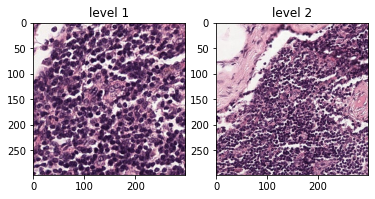

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(X_level_1_train[0])
plt.title(label="level 1")
plt.subplot(1, 2, 2)
plt.imshow(X_level_2_train[0])
plt.title(label="level 2")

generate training patches

In [ ]:
X_level_1_train, X_level_2_train, Y_train = patch_generator(train_slides, train_masks, zoom_level_1=0, zoom_level_2=1)

processing slide: 1, length of normal pixel: 806458, length of tumor pixel: 156981
processing slide: 2, length of normal pixel: 734434, length of tumor pixel: 47306
processing slide: 3, length of normal pixel: 1662065, length of tumor pixel: 187580
processing slide: 4, length of normal pixel: 1018852, length of tumor pixel: 1028065


In [ ]:
print("shape of level 1 training patch: {}".format(X_level_1_train.shape))
print("shape of level 2 training patch: {}".format(X_level_2_train.shape))
print("length of labels: {}".format(len(Y_train)))

shape of level 1 training patch: (2000, 299, 299, 3)
shape of level 2 training patch: (2000, 299, 299, 3)
length of labels: 2000


generate validation patches

In [ ]:
X_level_1_val, X_level_2_val, Y_val = patch_generator(val_slides, val_masks, zoom_level_1=0, zoom_level_2=1)

processing slide: 1, length of normal pixel: 648095, length of tumor pixel: 130695
processing slide: 2, length of normal pixel: 1862296, length of tumor pixel: 61257


In [ ]:
print("shape of level 1 validation patch: {}".format(X_level_1_val.shape))
print("shape of level 2 validation patch: {}".format(X_level_2_val.shape))
print("length of labels: {}".format(len(Y_val)))

shape of level 1 validation patch: (1000, 299, 299, 3)
shape of level 2 validation patch: (1000, 299, 299, 3)
length of labels: 1000


#### Save/Load patches to Google Drive

save

In [ ]:
save_path = '/content/gdrive/MyDrive/ADL_Project/train_patch'
np.save(os.path.join(save_path, 'zoom_level_1.npy'), X_level_1_train)
np.save(os.path.join(save_path, 'zoom_level_2.npy'), X_level_2_train)
np.save(os.path.join(save_path, 'train_label.npy'), Y_train)


In [ ]:
save_path = '/content/gdrive/MyDrive/ADL_Project/val_patch'
np.save(os.path.join(save_path, 'zoom_level_1.npy'), X_level_1_val)
np.save(os.path.join(save_path, 'zoom_level_2.npy'), X_level_2_val)
np.save(os.path.join(save_path, 'val_label.npy'), Y_val)

load

In [11]:
load_path = '/content/gdrive/MyDrive/ADL_Project/train_patch'
X_level_1_train = np.load(os.path.join(load_path, 'zoom_level_1.npy'))
X_level_2_train = np.load(os.path.join(load_path, 'zoom_level_2.npy'))
Y_train = np.load(os.path.join(load_path, 'train_label.npy'))

Text(0.5, 1.0, 'level 2')

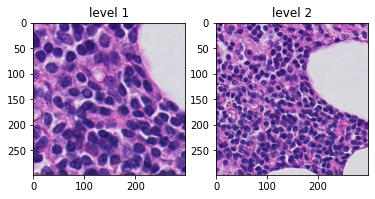

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(X_level_1_train[666])
plt.title(label="level 1")
plt.subplot(1, 2, 2)
plt.imshow(X_level_2_train[666])
plt.title(label="level 2")

In [ ]:
np.unique(Y_train, return_counts=True)

(array([0, 1]), array([ 983, 1017]))

In [12]:
load_path = '/content/gdrive/MyDrive/ADL_Project/val_patch'
X_level_1_val = np.load(os.path.join(load_path, 'zoom_level_1.npy'))
X_level_2_val = np.load(os.path.join(load_path, 'zoom_level_2.npy'))
Y_val = np.load(os.path.join(load_path, 'val_label.npy'))

Text(0.5, 1.0, 'level 2')

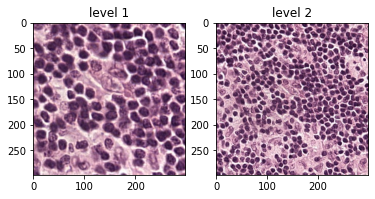

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(X_level_1_val[120])
plt.title(label="level 1")
plt.subplot(1, 2, 2)
plt.imshow(X_level_2_val[120])
plt.title(label="level 2")

In [ ]:
np.unique(Y_val, return_counts=True)

(array([0, 1]), array([494, 506]))

## Model training

In [13]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Data generator

In [14]:
IMG_SHAPE = (299, 299, 3)
BATCH_SIZE = 16

Training Data Generator

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255,
                                   rotation_range=90, shear_range=0.2, brightness_range=[0.7, 1.3])
train_ds_1 = train_datagen.flow(X_level_1_train, Y_train, batch_size=BATCH_SIZE, seed=666)
train_ds_2 = train_datagen.flow(X_level_2_train, batch_size=BATCH_SIZE, seed=666)
train_ds = zip(train_ds_1, train_ds_2)

In [ ]:
for (image_batch, label_batch), image_batch_2 in train_ds:
  print(image_batch.shape, label_batch.shape, image_batch_2.shape)
  break

(16, 299, 299, 3) (16,) (16, 299, 299, 3)


Validation Data Generator

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_ds_1 = val_datagen.flow(X_level_1_val, Y_val, batch_size=BATCH_SIZE, seed=666)
val_ds_2 = val_datagen.flow(X_level_2_val, batch_size=BATCH_SIZE, seed=666)
val_ds = zip(val_ds_1, val_ds_2)

In [ ]:
for (image_batch, label_batch), image_batch_2 in val_ds:
  print(image_batch.shape, label_batch.shape, image_batch_2.shape)
  break

(16, 299, 299, 3) (16,) (16, 299, 299, 3)


Cache and Prefetch

In [ ]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds_1 = train_ds_1.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# train_ds_2 = train_ds_2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds_1 = val_ds_1.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds_2 = val_ds_2.cache().prefetch(buffer_size=AUTOTUNE)

#### Transfer Learning with InceptionV3

In [ ]:
input_1 = Input(shape=IMG_SHAPE) 
input_2 = Input(shape=IMG_SHAPE)

base_model_1 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
base_model_1.trainable = False

base_model_2 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')
base_model_2.trainable = False

model_1 = Sequential()
model_1.add(base_model_1)
model_1.add(GlobalAveragePooling2D())
encoded_model_1 = model_1(input_1)

model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(GlobalAveragePooling2D())
encoded_model_2 = model_2(input_2)

# Concatenate the two level models
merged = concatenate([encoded_model_1, encoded_model_2])

dense = Dense(128, activation='relu')(merged)
dense = Dropout(0.2)(dense)
#add a binary classifier on top
output = Dense(1, activation='sigmoid')(dense)

# final model
model = Model(inputs=[input_1, input_2], outputs=output)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         21802784    input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         21802784    input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

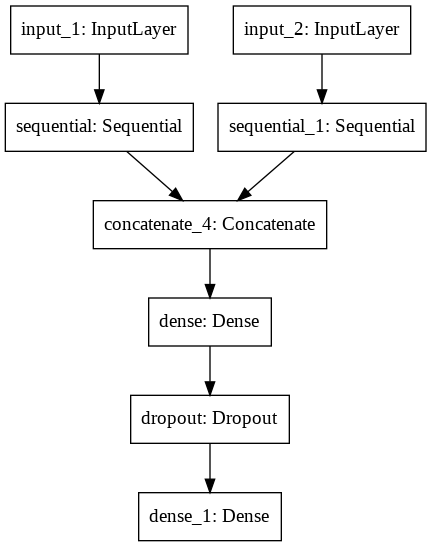

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

##### Sanity Check: fit model on single batch 

In [ ]:
(image_batch_level_1, label_batch), image_batch_level_2 = next(iter(train_ds))

In [ ]:
for _ in range(100):
  metrics = model.train_on_batch(x=[image_batch_level_1, image_batch_level_2], y=label_batch)
# metrics is a list (loss is metrics[0], accuracy is metrics[1])
print('the loss is: {} and the accuracy is: {}'.format(metrics[0], metrics[1]))

the loss is: 0.0016419035382568836 and the accuracy is: 1.0


In [ ]:
for prediction, answer in zip(model.predict(x=[image_batch_level_1, image_batch_level_2]), label_batch):
  print(prediction, answer)

[6.85282e-05] 0
[0.00149474] 0
[0.99975044] 1
[0.99967885] 1
[0.9989472] 1
[0.99748224] 1
[0.99780124] 1
[0.99941134] 1
[0.00314317] 0
[0.9995677] 1
[0.9965403] 1
[0.00108253] 0
[0.999451] 1
[0.00013868] 0
[0.99911577] 1
[0.00174714] 0


##### Metrics

In [ ]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

##### Code to evaluate on the validation dataset
evaluate for a fixed number of steps (batches)

In [ ]:
def evaluate(max_steps=None):
  steps = 0
  for (image_batch_level_1, label_batch), image_batch_level_2 in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[image_batch_level_1, image_batch_level_2])
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

##### Checkpoints

In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/ADL_Project/checkpoints'
# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

Restore the latest checkpoint (if it exists).

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

##### train the model

In [ ]:
# test to see if step per epoch is effective
# count = 0
# for (image_batch_level_1, label_batch), image_batch_level_2 in train_ds:
#   print(count, image_batch_level_1.shape)
#   print(label_batch.shape)
#   count += 1
#   if count == len(Y_train)/BATCH_SIZE:
#     break

In [ ]:
import time
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  count = 0
  for (image_batch_level_1, label_batch), image_batch_level_2 in train_ds:
    # print(image_batch_level_1.shape)
    # print(label_batch.shape)
    count += 1
    if count == len(Y_train)/BATCH_SIZE:
      break
    result = model.train_on_batch(x=[image_batch_level_1, image_batch_level_2], y=label_batch)
    
    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Save a checkpoint after each epoch
  print("Saving weights")
  model.save_weights(os.path.join('/content/gdrive/MyDrive/ADL_Project/Train_batch_cktp', 'model'))

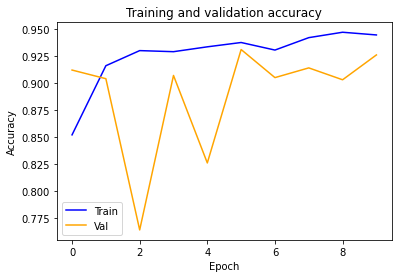

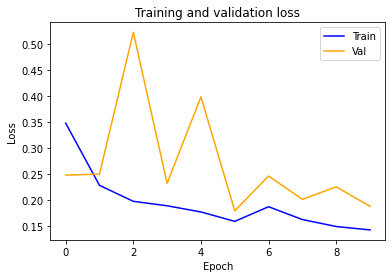

In [ ]:
def plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history):

  epochs = range(len(train_loss_history))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, train_acc_history, color='blue', label='Train')
  plt.plot(epochs, val_acc_history, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, train_loss_history, color='blue', label='Train')
  plt.plot(epochs, val_loss_history, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [ ]:
# Save the Model
model_name = 'Model.h5'
model.save(os.path.join('/content/gdrive/MyDrive/ADL_Project', model_name))

## Model testing

In [19]:
model_name = 'Model.h5'
model = tf.keras.models.load_model(os.path.join('/content/gdrive/MyDrive/ADL_Project', model_name))

### get test data

In [ ]:
print(test_slides)
print(test_masks)

[OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_084.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_091.tif')]
[OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_084_mask.tif'), OpenSlide('/content/gdrive/MyDrive/ADL_Project/slides/tumor_091_mask.tif')]


In [16]:
def predict_row_patches(model, patchs_level_1, patchs_level_2, masks_level_1, tissue_percentage=20):
  """
  output: true labels of a row, predicted labels of a row
  """
  true = np.array(list(map(get_label, masks_level_1)))
  pred = model.predict([patchs_level_1, patchs_level_2]).reshape(patchs_level_1.shape[0],)

  # for a patch have less than tissue_percentage tissue, we classify it as normal
  for i in range(len(patchs_level_1.shape[0])):
    if find_tissue_percentage(patchs_level_1[i]) <= tissue_percentage:
      pred[i] = 0

  return true, pred

In [18]:
def scan_test_slide(slide, tumor_mask, model, zoom_level_1=0, zoom_level_2=1, patch_size=299):
  """
  output: 2D array of actual labels and 2D array of predicted labels
  """
  zoom_level_1_factor = slide.level_downsamples[zoom_level_1]
  zoom_level_2_factor = slide.level_downsamples[zoom_level_2]
  Width_level_1, Height_level_1 = slide.level_dimensions[zoom_level_1]
  Width_level_2, Height_level_2 = slide.level_dimensions[zoom_level_2]

  patch_per_row = Width_level_1 // (patch_size * zoom_level_1_factor)
  patch_per_column = Height_level_1 // (patch_size * zoom_level_2_factor)

  # predict labels row by row to save RAM
  prediction = np.zeros((patch_per_row, patch_per_column)).astype(float)
  actual = np.zeros((patch_per_row, patch_per_column)).astype(int)

  for row in range(patch_per_row):
    patch_zoom_level_1, patch_zoom_level_2, mask = [], [], []
    for col in range(patch_per_column):
      x = (patch_size // 2 * zoom_level_2_factor) + row * patch_size * zoom_level_1_factor
      y = (patch_size // 2 * zoom_level_2_factor) + col * patch_size * zoom_level_1_factor

      patch_image_level_1, patch_mask_level_1 = get_patch(slide, tumor_mask, x, y, zoom_level_1, patch_size)
      patch_image_level_2, patch_mask_level_2 = get_patch(slide, tumor_mask, x, y, zoom_level_2, patch_size)

      patch_image_level_1, patch_image_level_2 = patch_image_level_1/255, patch_image_level_2/255

      patch_zoom_level_1.append(patch_image_level_1)
      patch_zoom_level_2.append(patch_image_level_2)
      mask.append(patch_mask_level_1) 

    patch_zoom_level_1 = np.array(patch_zoom_level_1)
    patch_zoom_level_2 = np.array(patch_zoom_level_2)   
    actual[row,:], prediction[row,:] = predict_row_patches(model, patch_zoom_level_1, patch_zoom_level_2, mask)


  return actual, prediction

### make prediction

##### save results to drive

In [20]:
result_path = '/content/gdrive/MyDrive/ADL_Project/test_result'

In [ ]:
actual_084, prediction_084 = scan_test_slide(test_slides[0], test_masks[0], model)
np.save(os.path.join(result_path, 'actual_084'), actual_084)
np.save(os.path.join(result_path, 'prediction_084'), prediction_084)

In [ ]:
actual_091, prediction_091 = scan_test_slide(test_slides[1], test_masks[1], model)
np.save(os.path.join(result_path, 'actual_091'), actual_091)
np.save(os.path.join(result_path, 'prediction_091'), prediction_091)

##### load results from drive

In [22]:
actual_084 = np.load(os.path.join(result_path, 'actual_084'))
prediction_084 = np.load(os.path.join(result_path, 'prediction_084'))
actual_091 = np.load(os.path.join(result_path, 'actual_091'))
prediction_091 = np.load(os.path.join(result_path, 'actual_091'))

#####  make plots

In [114]:
import cv2
def plot_result(slide, tumor_mask, actual, prediction, zoom_level, threshold):
  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=zoom_level, 
                          width=slide.level_dimensions[zoom_level][0], 
                          height=slide.level_dimensions[zoom_level][1])
  mask_image = read_slide(tumor_mask, 
                          x=0,
                          y=0, 
                          level=zoom_level, 
                          width=tumor_mask.level_dimensions[zoom_level][0], 
                          height=tumor_mask.level_dimensions[zoom_level][1])[:,:,0]
  
  mask = cv2.resize(prediction.astype('float32'), (slide_image.shape[1],slide_image.shape[0]))
  mask = (mask >= threshold).astype(int)

  plt.figure(figsize=(10, 10))
  ax = plt.subplot(1, 2, 1)
  plt.imshow(slide_image)
  plt.imshow(mask, cmap='jet', alpha=0.5)
  plt.title(label="predicted heatmap")

  ax = plt.subplot(1, 2, 2)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)
  plt.title(label="actual heatmap")

##### evaluate performance

In [140]:
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score, roc_curve 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay 

In [143]:
def metrics_evaluate(actual, prediction, threshold):
  y_true = actual.reshape(-1,)
  prediction = prediction.reshape(-1,)
  y_pred = (prediction>threshold).astype(int)
  target_names = ['normal tissue', 'tumor']
  # print(classification_report(y_true, y_pred, target_names=target_names))

  fpr, tpr, _ = roc_curve(y_true, prediction)
  roc_auc = auc(fpr, tpr)
  template = 'AUC: {:.4f}, F1 Score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, ROC AUC Score: {:.4f}'
  print(template.format(roc_auc, f1_score(y_true, y_pred), precision_score(y_true, y_pred),
                        recall_score(y_true, y_pred), roc_auc_score(y_true, prediction)))

  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='estimator')
  display.plot()  
  plt.show()      

In [136]:
metrics_evaluate(actual_084, prediction_084, threshold=0.7)

               precision    recall  f1-score   support

normal tissue       0.99      0.99      0.99     61373
        tumor       0.13      0.27      0.18       472

     accuracy                           0.98     61845
    macro avg       0.56      0.63      0.58     61845
 weighted avg       0.99      0.98      0.98     61845



In [137]:
metrics_evaluate(actual_091, prediction_091, threshold=0.7)

               precision    recall  f1-score   support

normal tissue       1.00      1.00      1.00     35315
        tumor       1.00      1.00      1.00       616

     accuracy                           1.00     35931
    macro avg       1.00      1.00      1.00     35931
 weighted avg       1.00      1.00      1.00     35931



## Result

### slide 84

AUC: 0.9305, F1 Score: 0.1791, Precision: 0.1338, Recall: 0.2712, ROC AUC Score: 0.9305


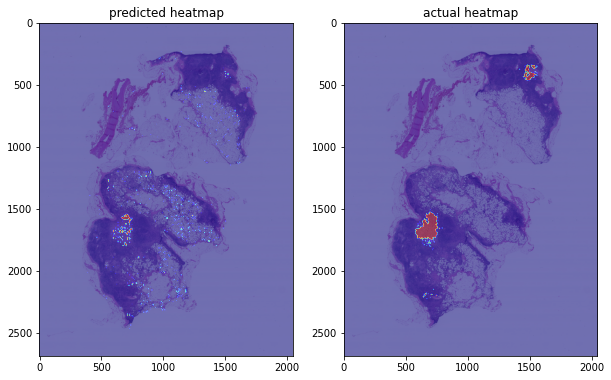

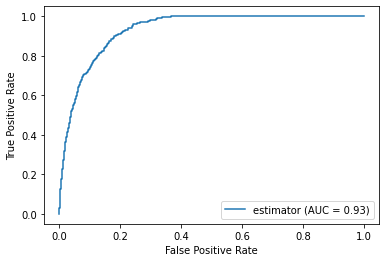

In [144]:
plot_result(test_slides[0], test_masks[0], actual_084, prediction_084, zoom_level=5, threshold=0.7)
metrics_evaluate(actual_084, prediction_084, threshold=0.7)

AUC: 0.9305, F1 Score: 0.1812, Precision: 0.1203, Recall: 0.3665, ROC AUC Score: 0.9305


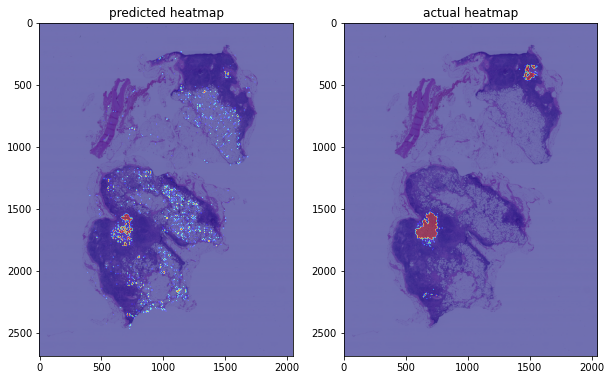

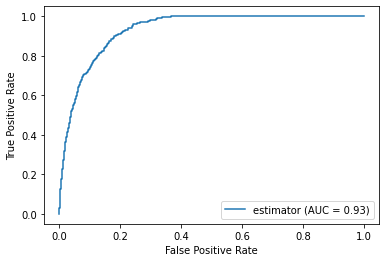

In [145]:
plot_result(test_slides[0], test_masks[0], actual_084, prediction_084, zoom_level=5, threshold=0.6)
metrics_evaluate(actual_084, prediction_084, threshold=0.6)

### slide 91

AUC: 1.0000, F1 Score: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC AUC Score: 1.0000


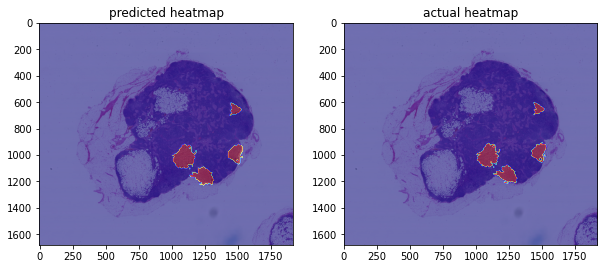

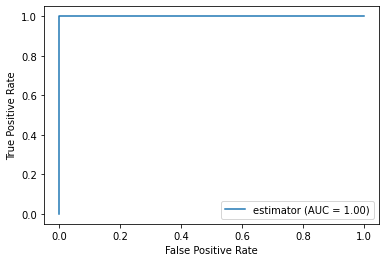

In [146]:
plot_result(test_slides[1], test_masks[1], actual_091, prediction_091, zoom_level=5, threshold=0.7)
metrics_evaluate(actual_091, prediction_091, threshold=0.7)

AUC: 1.0000, F1 Score: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC AUC Score: 1.0000


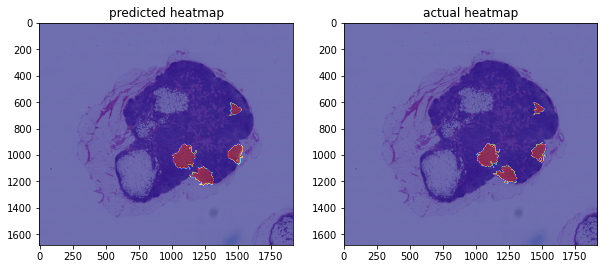

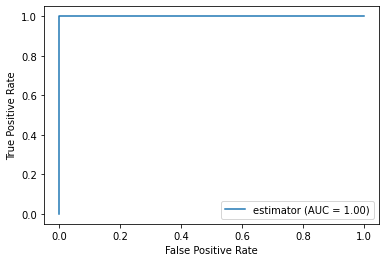

In [149]:
plot_result(test_slides[1], test_masks[1], actual_091, prediction_091, zoom_level=5, threshold=0.6)
metrics_evaluate(actual_091, prediction_091, threshold=0.6)